# Multi-Model Sensitivity Analysis

This notebook performs Root Cause Analysis on the top detected anomalies for all three sequentially trained models.

**Methods Used:**
- **Transformer + OC-SVM**: Uses **Occlusion (Feature Ablation)**. Since OC-SVM is not differentiable, we mask features one by one to measure their impact on the anomaly score.
- **PRAE & PNN**: Uses **Integrated Gradients (IG)**. These are fully differentiable neural networks, allowing us to compute exact feature attribution gradients.

**Objectives:**
1. Iterate through `transformer_ocsvm`, `prae`, and `pnn`.
2. Detect the most severe anomaly on the Test Day (Day 25).
3. Compute feature importance.
4. Visualize results (Global Importance Bars & Temporal Heatmaps where applicable).

In [1]:
import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import sys
sys.path.append("..")

from PDMM import preprocessing as prep
from PDMM import machine_learning as ml
from PDMM import visualization as viz
from PDMM.pipeline import AnomalyDetectionPipeline, load_model, LazySequenceDataset, FlattenWrapper

In [2]:
# Configuration
DATASET = 'TOTF'
SCALER = 'box-cox'
DATA_DIR = '../data/TOTF.PA-book'
MODEL_DIR = '../models'
TEST_DAY_INDEX = 5  # Day 25, 0 indexed
SEQ_LENGTH = 25
FEATURE_SETS = ['base', 'tao', 'poutre', 'hawkes', 'ofi']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [3]:
# We will analyze all three sequential models
MODELS_TO_ANALYZE = ['transformer_ocsvm', 'prae', 'pnn']

# Number of top anomalies to analyze
TOP_N = 10

## 2. Load Data & Iterate Models

Loading Test Data: 2015-01-09-TOTF.PA-book.csv.gz
Pipeline initialized on device: cuda
Loading data from ../data/TOTF.PA-book\2015-01-09-TOTF.PA-book.csv.gz...
Successfully loaded 1278519 rows.
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 131
Data loaded. Starting Analysis Loop...

Analyzing Model: transformer_ocsvm
Pipeline initialized on device: cuda
OC-SVM Detector loaded.
Top Anomaly Found at Index: 173165 (Score: 1.3482)
Method: OCCLUSION (Feature Ablation)


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\visualization.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Importance', y='Feature', palette='viridis')


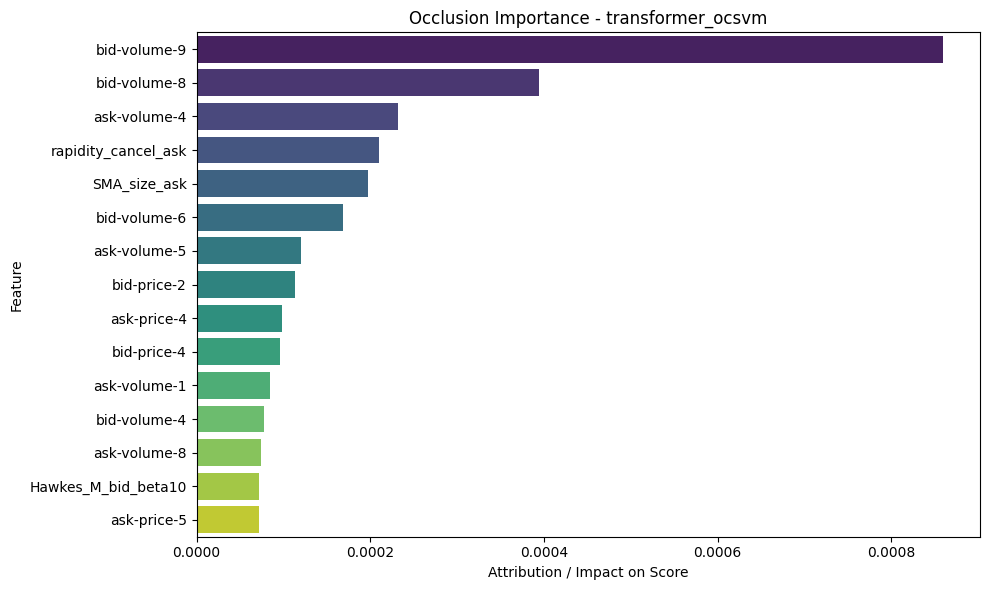



Analyzing Model: prae
Pipeline initialized on device: cuda
Top Anomaly Found at Index: 1277534 (Score: 132.8804)
Method: INTEGRATED GRADIENTS


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\visualization.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Importance', y='Feature', palette='viridis')


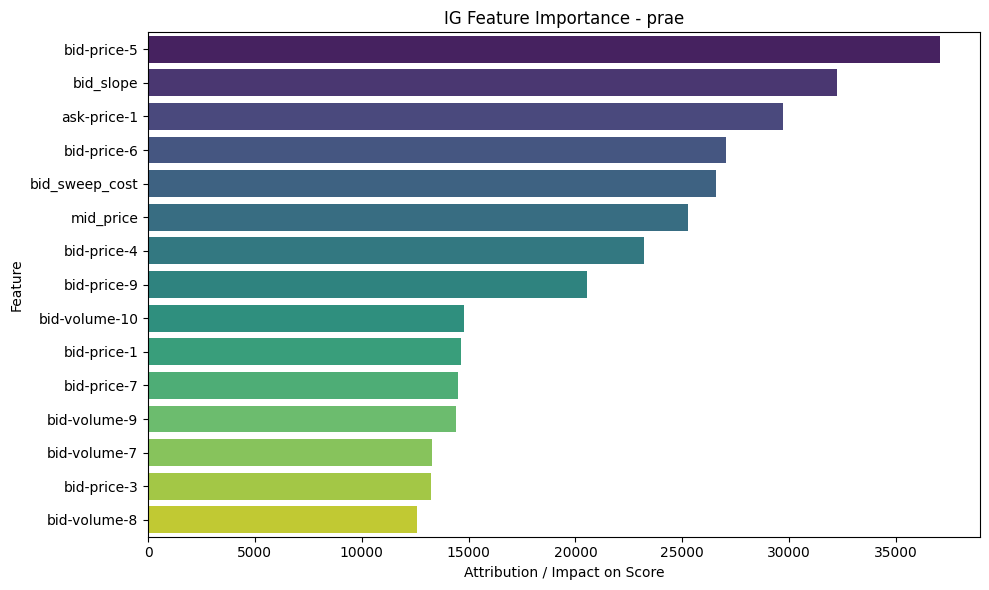

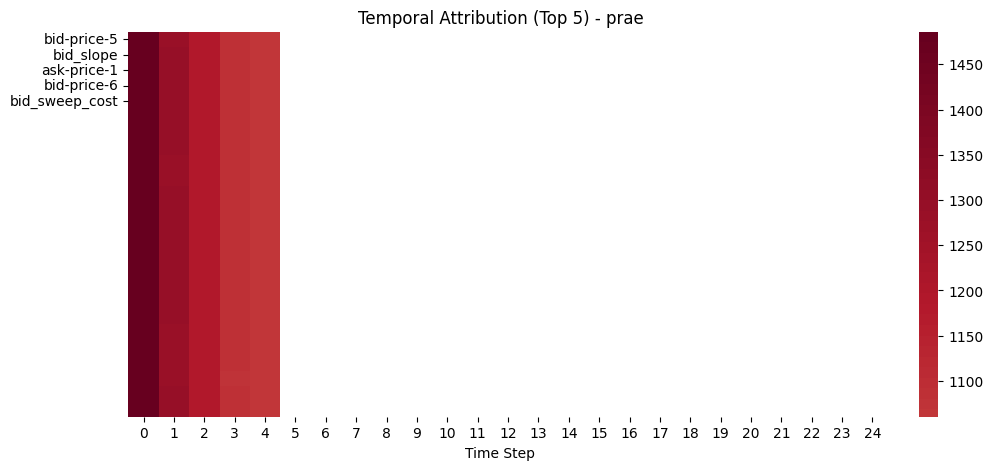



Analyzing Model: pnn
Pipeline initialized on device: cuda
Top Anomaly Found at Index: 1628 (Score: 0.2772)
Method: INTEGRATED GRADIENTS


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\visualization.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Importance', y='Feature', palette='viridis')


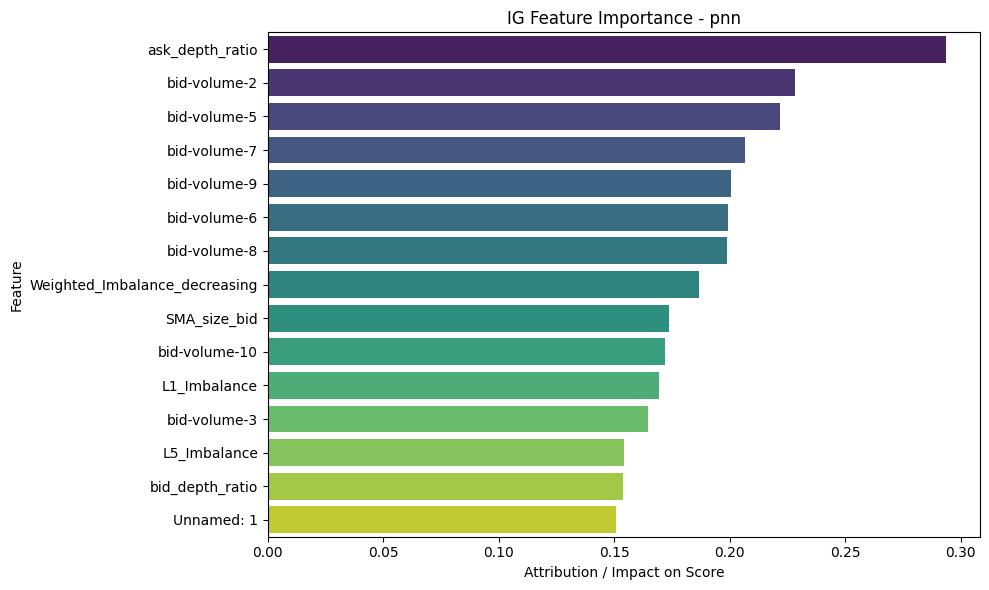

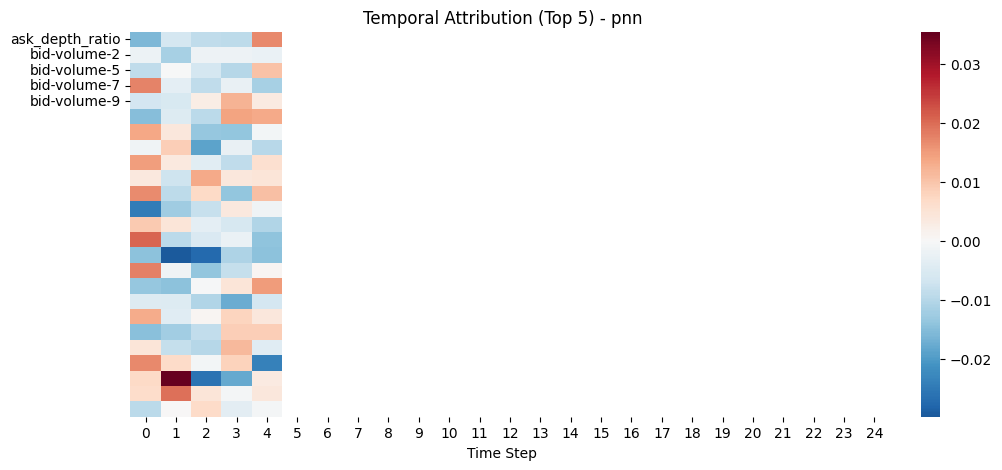

In [ ]:
# Pre-load test data once
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(('.csv', '.csv.gz'))])
test_file = files[TEST_DAY_INDEX]
print(f"Loading Test Data: {test_file}")

data_pipeline = AnomalyDetectionPipeline()
data_pipeline.load_data(os.path.join(DATA_DIR, test_file))
data_pipeline.engineer_features(FEATURE_SETS)
base_features = data_pipeline.processed_df.copy()

print("Data loaded. Starting Analysis Loop...\n")

for model_name in MODELS_TO_ANALYZE:
    print("="*60)
    print(f"Analyzing Model: {model_name}")
    print("="*60)
    
    # CONFIG & SETUP
    config_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{model_name}_sequential_config.json"
    weights_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{model_name}_sequential_weights.pth"
        
    with open(config_path, 'r') as f: config = json.load(f)
    
    # Align features
    data_pipeline.feature_names = config['feature_names']
    # Patch input_dim
    if 'input_dim' not in config: config['input_dim'] = len(config['feature_names'])
        
    # Filter DF columns
    current_df = base_features[config['feature_names']]
    
    # Load Scaler
    scaler_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_transformer_ocsvm_sequential_scaler.pkl"
    scaler = joblib.load(scaler_path)
    test_scaled = scaler.transform(current_df.values)
    
    # Load Model
    dummy_input = pd.DataFrame(test_scaled[:100], columns=config['feature_names'])
    mp, _ = load_model(config_path, dummy_input, config['feature_names'])
    
    state_dict = torch.load(weights_path, map_location=device)
    if 'mu' in state_dict: del state_dict['mu']
    mp.model.load_state_dict(state_dict, strict=False)
    mp.model.eval()
    
    # Load OC-SVM
    if 'transformer_ocsvm' in model_name:
        detector_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{model_name}_sequential_ocsvm_detector.pkl"
        if os.path.exists(detector_path):
            mp.detector = joblib.load(detector_path)
            print("OC-SVM Detector loaded.")

    # Detect top anomaly
    # Create DataLoader
    dataset = LazySequenceDataset(test_scaled, SEQ_LENGTH)
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
    
    scores = []
    with torch.no_grad():
        for batch_x, _ in loader:
            batch_x = batch_x.to(device)
            
            if 'pnn' in model_name:
                batch_flat = batch_x.view(batch_x.size(0), -1)
                output = mp.model(batch_flat)
                mu, sigma, alpha = output
                scores.extend(sigma.flatten().cpu().numpy())
            
            elif 'transformer_ocsvm' in model_name:
                # Reconstruction Error + OC-SVM Score
                if hasattr(mp, 'detector'):
                    latent = mp.model.encoder(batch_x)
                    latent_np = latent.cpu().numpy()
                    ocsvm_scores = -mp.detector.decision_function(latent_np)
                    scores.extend(ocsvm_scores)
                else:
                    rec = mp.model(batch_x)
                    err = torch.mean((batch_x - rec)**2, dim=[1,2])
                    scores.extend(err.cpu().numpy())
            
            elif 'prae' in model_name:
                output = mp.model(batch_x)
                rec = output[0] if isinstance(output, tuple) else output
                err = torch.mean((batch_x - rec)**2, dim=[1,2])
                scores.extend(err.cpu().numpy())
                
    scores = np.array(scores)
    top_idx = np.argmax(scores)
    print(f"Top Anomaly Found at Index: {top_idx} (Score: {scores[top_idx]:.4f})")
    
    # Extract the anomalous sequence
    x_seq_tensor = torch.tensor(test_scaled[top_idx : top_idx + SEQ_LENGTH], dtype=torch.float32).unsqueeze(0).to(device)
    
    # Sensitivity Analysis
    if 'transformer_ocsvm' in model_name:
        print("Method: OCCLUSION (Feature Ablation)")
        importance_df = ml.explain_occlusion(
            mp, 
            x_seq_tensor, 
            config['feature_names'], 
            baseline_mode='mean'
        )
        
        # Visualize
        viz.plot_global_importance(importance_df, title=f"Occlusion Importance - {model_name}", save_path=f'../results/sensitivity_analysis/figures/{DATASET}_{SCALER}_{model_name}_sequential_feature_importance.png')
        
    else:
        print("Method: INTEGRATED GRADIENTS")
        if 'pnn' in model_name:
            model_to_explain = FlattenWrapper(mp.model)
            
            # Target function: Maximize sigma
            target_fn = lambda output, inputs: output[1].sum()
        else: 
            # PRAE
            model_to_explain = mp.model

            # Target function: Maximize Reconstruction Error
            def target_fn(output, inputs):
                rec = output[0] if isinstance(output, tuple) else output
                return torch.sum((rec - inputs) ** 2, dim=[1, 2])

        IG = ml.IntegratedGradients(model_to_explain)
        attributions = IG.attribute(x_seq_tensor, target_func=target_fn, n_steps=50)
        attrs_np = attributions.detach().cpu().numpy()
        
        # Global Importance (Sum absolute values)
        global_imp = np.sum(np.abs(attrs_np[0]), axis=0)
        ig_df = pd.DataFrame({'Feature': config['feature_names'], 'Importance': global_imp})
        viz.plot_global_importance(ig_df, title=f"IG Feature Importance - {model_name}", save_path=f'../results/sensitivity_analysis/figures/{DATASET}_{SCALER}_{model_name}_sequential_feature_importance.png')
        
        # Temporal Heatmap
        top_5 = ig_df.sort_values('Importance', ascending=False).head(5)
        top_5_indices = [config['feature_names'].index(f) for f in top_5['Feature']]
        
        heatmap_data = attrs_np[0, :, top_5_indices].T
        plt.figure(figsize=(12, 5))
        sns.heatmap(heatmap_data, cmap="RdBu_r", center=0, 
                    yticklabels=top_5['Feature'].values, 
                    xticklabels=range(SEQ_LENGTH))
        plt.title(f"Temporal Attribution (Top 5) - {model_name}")
        plt.xlabel("Time Step")

        plt.savefig(f'../results/sensitivity_analysis/figures/{DATASET}_{SCALER}_{model_name}_sequential_temporal_attribution.png')
        plt.show()
    
    print("\n")

Loading Test Data: 2015-01-09-TOTF.PA-book.csv.gz
Pipeline initialized on device: cuda
Loading data from ../data/TOTF.PA-book\2015-01-09-TOTF.PA-book.csv.gz...
Successfully loaded 1278519 rows.
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Feature Engineering complete. Total features: 131
Data loaded. Starting Analysis Loop...

Analyzing Model: transformer_ocsvm
Pipeline initialized on device: cuda
OC-SVM Detector loaded.
Examining Top 10 Anomalies.
Score Range: 1.3482 - 1.3482
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)
Method: OCCLUSION (Feature Ablation)


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\visualization.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Importance', y='Feature', palette='viridis')


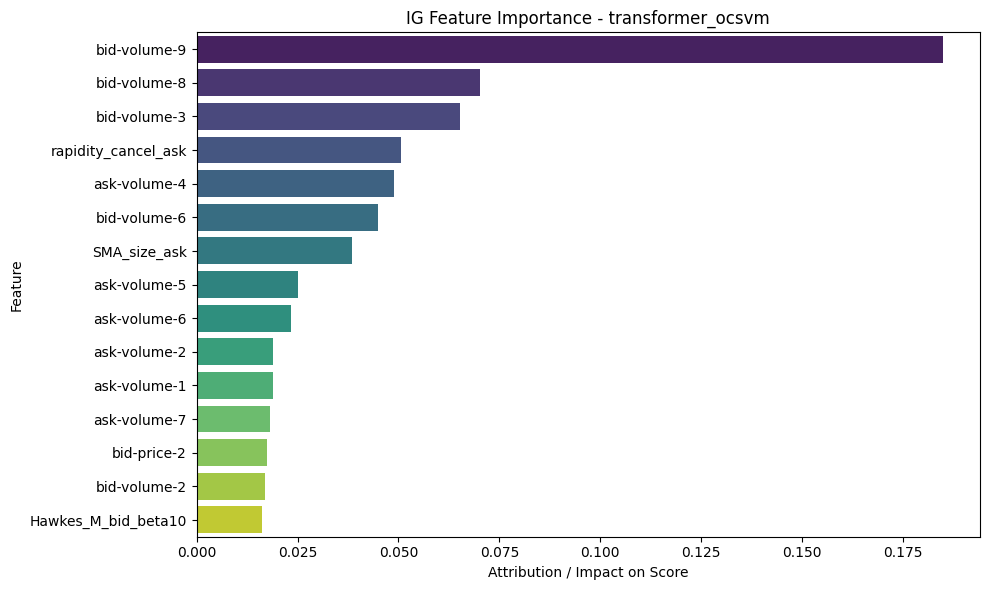



Analyzing Model: prae
Pipeline initialized on device: cuda
Examining Top 10 Anomalies.
Score Range: 132.5917 - 132.8804
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\visualization.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Importance', y='Feature', palette='viridis')


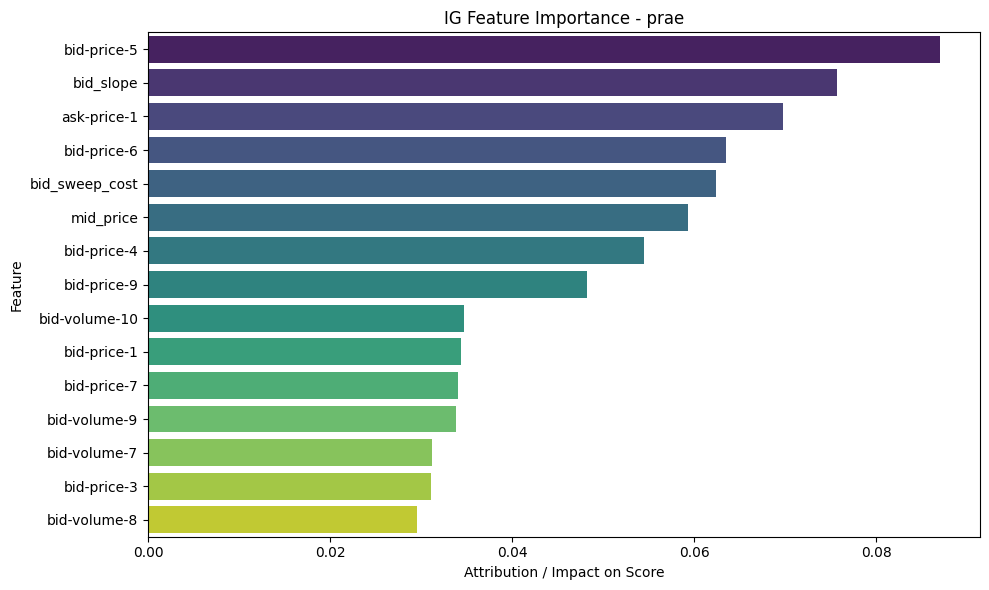



Analyzing Model: pnn
Pipeline initialized on device: cuda
Examining Top 10 Anomalies.
Score Range: 0.2279 - 0.2772
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS
Method: INTEGRATED GRADIENTS


c:\Users\adoni\Desktop\Projet MDS\MDS-Market_Manipulation\notebooks\..\PDMM\visualization.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Importance', y='Feature', palette='viridis')


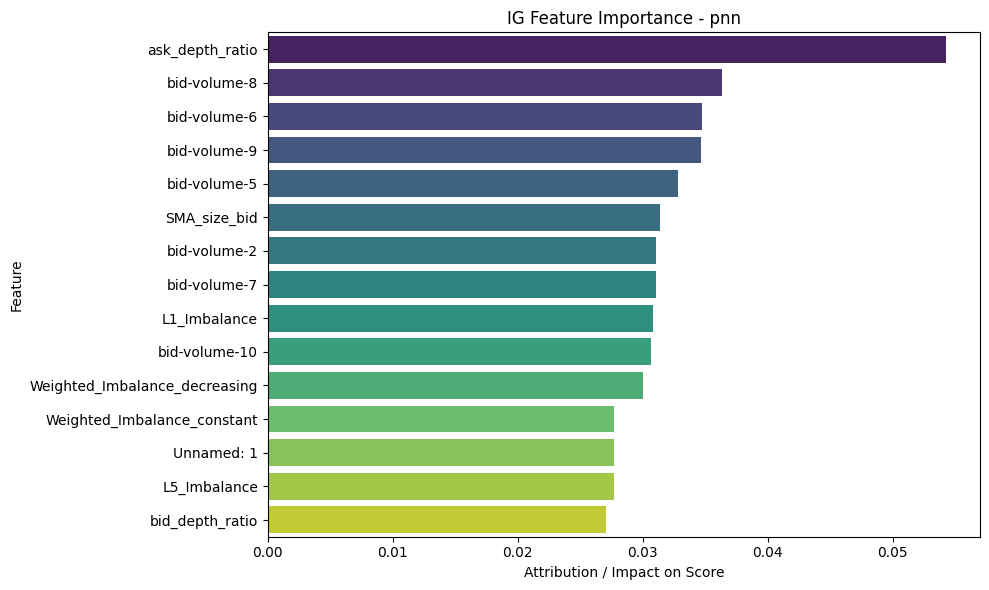

In [4]:
# Pre-load test data once
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(('.csv', '.csv.gz'))])
test_file = files[TEST_DAY_INDEX]
print(f"Loading Test Data: {test_file}")

data_pipeline = AnomalyDetectionPipeline()
data_pipeline.load_data(os.path.join(DATA_DIR, test_file))
data_pipeline.engineer_features(FEATURE_SETS)
base_features = data_pipeline.processed_df.copy()

print("Data loaded. Starting Analysis Loop...\n")

for model_name in MODELS_TO_ANALYZE:
    print("="*60)
    print(f"Analyzing Model: {model_name}")
    print("="*60)
    
    # CONFIG & SETUP
    config_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{model_name}_sequential_config.json"
    weights_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{model_name}_sequential_weights.pth"
        
    with open(config_path, 'r') as f: config = json.load(f)
    
    # Align features
    data_pipeline.feature_names = config['feature_names']
    # Patch input_dim
    if 'input_dim' not in config: config['input_dim'] = len(config['feature_names'])
        
    # Filter DF columns
    current_df = base_features[config['feature_names']]
    
    # Load Scaler
    scaler_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_transformer_ocsvm_sequential_scaler.pkl"
    scaler = joblib.load(scaler_path)
    test_scaled = scaler.transform(current_df.values)
    
    # Load Model
    dummy_input = pd.DataFrame(test_scaled[:100], columns=config['feature_names'])
    mp, _ = load_model(config_path, dummy_input, config['feature_names'])
    
    state_dict = torch.load(weights_path, map_location=device)
    if 'mu' in state_dict: del state_dict['mu']
    mp.model.load_state_dict(state_dict, strict=False)
    mp.model.eval()
    
    # Load OC-SVM
    if 'transformer_ocsvm' in model_name:
        detector_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{model_name}_sequential_ocsvm_detector.pkl"
        if os.path.exists(detector_path):
            mp.detector = joblib.load(detector_path)
            print("OC-SVM Detector loaded.")

    # Detect top anomalies
    # Create DataLoader
    dataset = LazySequenceDataset(test_scaled, SEQ_LENGTH)
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
    mp.X_test = dataset

    scores = []
    with torch.no_grad():
        for batch_x, _ in loader:
            batch_x = batch_x.to(device)
            
            if 'pnn' in model_name:
                batch_flat = batch_x.view(batch_x.size(0), -1)
                output = mp.model(batch_flat)
                mu, sigma, alpha = output
                scores.extend(sigma.flatten().cpu().numpy())
            
            elif 'transformer_ocsvm' in model_name:
                # Reconstruction Error + OC-SVM Score
                if hasattr(mp, 'detector'):
                    latent = mp.model.encoder(batch_x)
                    latent_np = latent.cpu().numpy()
                    ocsvm_scores = -mp.detector.decision_function(latent_np)
                    scores.extend(ocsvm_scores)
                else:
                    rec = mp.model(batch_x)
                    err = torch.mean((batch_x - rec)**2, dim=[1,2])
                    scores.extend(err.cpu().numpy())
            
            elif 'prae' in model_name:
                output = mp.model(batch_x)
                rec = output[0] if isinstance(output, tuple) else output
                err = torch.mean((batch_x - rec)**2, dim=[1,2])
                scores.extend(err.cpu().numpy())
                
    scores = np.array(scores)
    top_n_indices = np.argsort(scores)[-TOP_N:][::-1]
    print(f"Examining Top {TOP_N} Anomalies.")
    print(f"Score Range: {scores[top_n_indices[-1]]:.4f} - {scores[top_n_indices[0]]:.4f}")
    

    # Sensitivity Analysis - Aggregate over Top N
    aggregate_importance = np.zeros(len(mp.feature_names))

    for i, idx in enumerate(top_n_indices):
        # input sequence for this anomaly
        input_seq, _ = mp.X_test[idx]
        input_seq = input_seq.unsqueeze(0).to(device)
        input_seq.requires_grad = True

        current_importance = None

        if model_name == 'transformer_ocsvm':
            print("Method: OCCLUSION (Feature Ablation)")
            importance_df = ml.explain_occlusion(
                mp, 
                input_seq, 
                config['feature_names'], 
                baseline_mode='mean'
            )

            occ_df = importance_df.set_index('Feature').reindex(config['feature_names'])
            current_importance = occ_df['Importance'].fillna(0).values

        else:
            print("Method: INTEGRATED GRADIENTS")
            if 'pnn' in model_name:
                model_to_explain = FlattenWrapper(mp.model)

                # Target function: Maximize sigma
                target_fn = lambda output, inputs: output[1].sum()
            else: 
                # PRAE
                model_to_explain = mp.model

                # Target function: Maximize Reconstruction Error
                def target_fn(output, inputs):
                    rec = output[0] if isinstance(output, tuple) else output
                    return torch.sum((rec - inputs) ** 2, dim=[1, 2])

            IG = ml.IntegratedGradients(model_to_explain)

            attributions = IG.attribute(input_seq, target_func=target_fn, n_steps=50)
            attrs_np = attributions.detach().cpu().numpy()

            current_importance = np.sum(np.abs(attrs_np[0]), axis=0)
        

        if current_importance is not None:
            current_importance = np.abs(current_importance)
            current_importance = current_importance / (np.sum(current_importance) + 1e-8)
            aggregate_importance += current_importance

    avg_importance = aggregate_importance / TOP_N

    # Visualization
    # Global Importance (Sum absolute values)
    ig_df = pd.DataFrame({'Feature': config['feature_names'], 'Importance': avg_importance})
    viz.plot_global_importance(ig_df, title=f"IG Feature Importance - {model_name}", save_path=f'../results/sensitivity_analysis/figures/{DATASET}_{SCALER}_{model_name}_sequential_feature_importance.png')
    
    # # Temporal Heatmap
    # top_5 = ig_df.sort_values('Importance', ascending=False).head(5)
    # top_5_indices = [config['feature_names'].index(f) for f in top_5['Feature']]
    # 
    # heatmap_data = avg_importance[0, :, top_5_indices].T
    # plt.figure(figsize=(12, 5))
    # sns.heatmap(heatmap_data, cmap="RdBu_r", center=0, 
    #             yticklabels=top_5['Feature'].values, 
    #             xticklabels=range(SEQ_LENGTH))
    # plt.title(f"Temporal Attribution (Top 5) - {model_name}")
    # plt.xlabel("Time Step")
    # 
    # plt.savefig(f'../results/sensitivity_analysis/figures/{DATASET}_{SCALER}_{model_name}_sequential_temporal_attribution.png')
    # plt.show()
    
    print("\n")